### First attempt at cleaning scheduled rent
The problem is that at random points of time the scheduled rent is either entered for the entire unit, for the actual bed itself.
Moreover sometimes this happens in the middle, sometimes at the start, sometimes at the end \
Other times, the amount is plain wrong (i.e. there are times where a 1bedroom is being charged $3500 for a majority of the time horizon) \
The fastest workaround is to basically apply a ceiling to replace these estimates with something more reasonable (i.e. an average asking price based on bedroom size)

In [9]:
import pandas as pd
import numpy as np

average_prices_df = pd.read_excel("Average Prices.xlsx", sheet_name=None)   
property_Name = "King Street Towers"  # Change as needed
# oneElevenDf = pd.read_csv("Properties/1Eleven_filtered_output.csv")         
kingStreetTowersDf = pd.read_csv("Properties/King_Street_Towers_filtered_output.csv")

def build_price_lookup(avg_prices_obj, property_name="1Eleven", prop_col="Property", type_col="Bedroom Type", price_col="Average Price"):
    if isinstance(avg_prices_obj, dict):
        if property_name in avg_prices_obj:
            dfp = avg_prices_obj[property_name].copy()
        else:
            dfp = pd.concat(avg_prices_obj.values(), ignore_index=True)
    else:
        dfp = avg_prices_obj.copy()

    dfp.columns = [str(c).strip() for c in dfp.columns]
    if prop_col in dfp.columns:
        dfp = dfp[dfp[prop_col].astype(str).str.strip().str.casefold() == property_name.casefold()]

    dfp[type_col] = dfp[type_col].astype(str).str.strip().str.upper()
    dfp[price_col] = pd.to_numeric(dfp[price_col], errors="coerce")

    price_map = dfp.groupby(type_col)[price_col].median().dropna().to_dict()
    return price_map


def clean_scheduled_rent(df, price_lookup, unit_col="Unit Type", rent_col="Scheduled Rent", bed_col="Bedroom Count", tolerance_pct=0.10, tolerance_abs=50):
    out = df.copy()

    out[rent_col] = pd.to_numeric(out[rent_col], errors="coerce")
    out[bed_col] = pd.to_numeric(out[bed_col], errors="coerce")
    out["_UNIT_KEY"] = out[unit_col].astype(str).str.strip().str.upper()

    out["expected_rent"] = out["_UNIT_KEY"].map(price_lookup)

    has_rent = out[rent_col].notna() & (out[rent_col] > 0)
    has_expected = out["expected_rent"].notna()
    mask = has_rent & has_expected

    out["scheduled_rent_cleaned"] = out[rent_col]
    out["clean_reason"] = np.where(mask, "as_is_check", "not_checked")

    def close_enough(given, expected):
        return (given - expected).abs() <= np.maximum(tolerance_abs, tolerance_pct * expected)

    given = out.loc[mask, rent_col]
    expected = out.loc[mask, "expected_rent"]
    within_now = close_enough(given, expected)

    out.loc[mask & within_now, "clean_reason"] = "kept_as_is"

    to_try_perbed = mask & ~within_now.reindex(out.index, fill_value=False)
    perbed = out.loc[to_try_perbed, rent_col] / out.loc[to_try_perbed, bed_col].replace(0, np.nan)
    perbed_within = close_enough(perbed, out.loc[to_try_perbed, "expected_rent"])

    out.loc[to_try_perbed & perbed_within.reindex(out.index, fill_value=False), "scheduled_rent_cleaned"] = perbed
    out.loc[to_try_perbed & perbed_within.reindex(out.index, fill_value=False), "clean_reason"] = "divided_by_bedrooms"

    still_off = to_try_perbed & ~perbed_within.reindex(out.index, fill_value=False)
    out.loc[still_off, "scheduled_rent_cleaned"] = out.loc[still_off, "expected_rent"]
    out.loc[still_off, "clean_reason"] = "replaced_with_average"

    out.loc[has_rent & ~has_expected, "clean_reason"] = "no_match_in_average_prices"

    out.drop(columns=["_UNIT_KEY"], inplace=True)

    return out

price_lookup = build_price_lookup(average_prices_df, property_name=property_Name)
# oneElevenDf_cleaned = clean_scheduled_rent(oneElevenDf, price_lookup, unit_col="Unit Type", rent_col="Scheduled Rent", bed_col="Bedroom Count", tolerance_pct=0.50, tolerance_abs=500)

# oneElevenDf_cleaned.to_csv("Properties_Cleaned_Rent/1Eleven_cleaned.csv", index=False)
kingStreetTowersDf_cleaned = clean_scheduled_rent(kingStreetTowersDf, price_lookup, unit_col="Unit Type", rent_col="Scheduled Rent", bed_col="Bedroom Count", tolerance_pct=0.50, tolerance_abs=500)

kingStreetTowersDf_cleaned.to_csv("Properties_Cleaned_Rent/King_Street_Towers_cleaned.csv", index=False)


C:\Users\JackE\AppData\Local\Temp\ipykernel_17888\1436118213.py:7: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  kingStreetTowersDf = pd.read_csv("Properties/King_Street_Towers_filtered_output.csv")


### Lease Length

Model summary for 17Hundred_filtered_output_standardized.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                 2.863e+05
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:28:47   Log-Likelihood:             2.6917e+05
No. Observations:              331989   AIC:                        -5.383e+05
Df Residuals:                  331967   BIC:                        -5.381e+05
Df Model:                          21                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2864780536.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


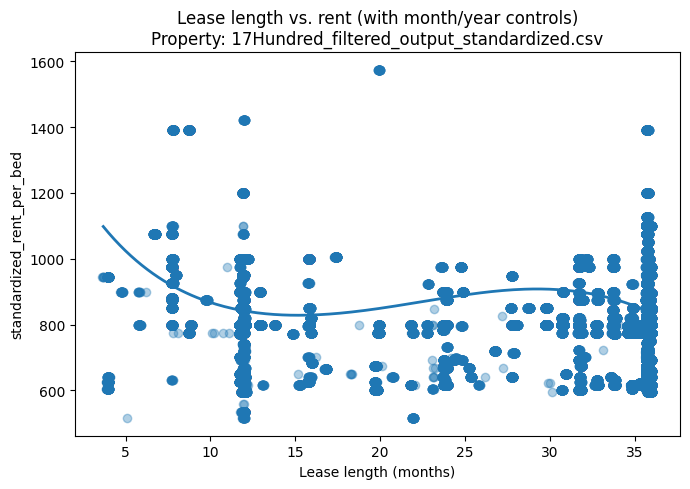

Model summary for 1Eleven_filtered_output_standardized.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     822.0
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:28:55   Log-Likelihood:                -64545.
No. Observations:              208620   AIC:                         1.291e+05
Df Residuals:                  208600   BIC:                         1.293e+05
Df Model:                          19                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2864780536.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


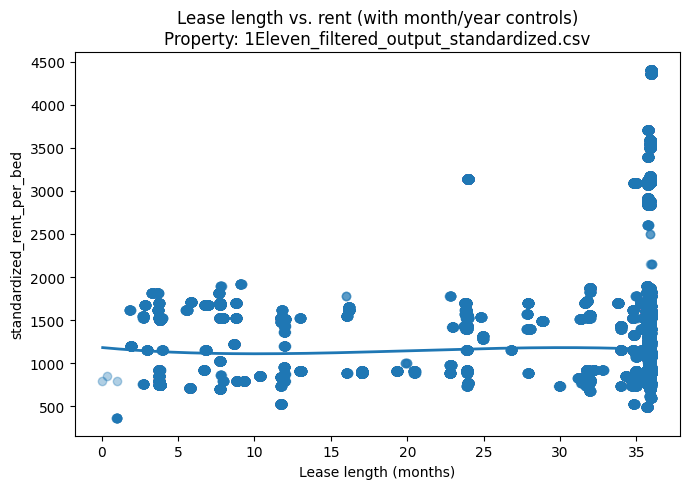

Model summary for 1Ten_on_Whyte_filtered_output_standardized.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                 1.392e+06
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:28:57   Log-Likelihood:                 30646.
No. Observations:               34711   AIC:                        -6.127e+04
Df Residuals:                   34698   BIC:                        -6.116e+04
Df Model:                          12                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2864780536.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


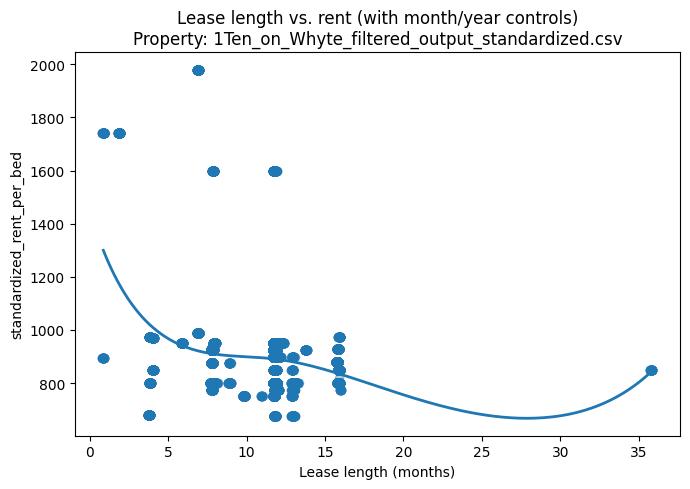

Model summary for 308_King_filtered_output_standardized.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     4330.
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:29:03   Log-Likelihood:             1.4942e+05
No. Observations:              206832   AIC:                        -2.988e+05
Df Residuals:                  206816   BIC:                        -2.987e+05
Df Model:                          15                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2864780536.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


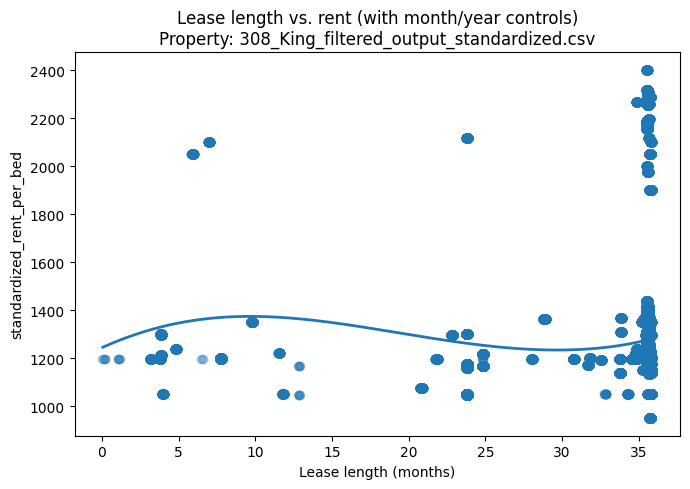

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 14
  warnings.warn('covariance of constraints does not have full '
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2864780536.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


Model summary for 417Nelson_filtered_output_standardized.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     2093.
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:29:05   Log-Likelihood:                 7479.4
No. Observations:               29575   AIC:                        -1.493e+04
Df Residuals:                   29559   BIC:                        -1.479e+04
Df Model:                          15                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

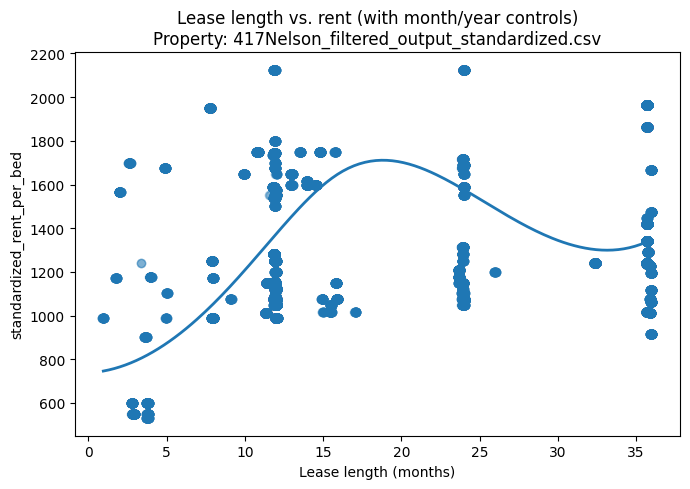

Model summary for ALMA_@_ByWard_Market_filtered_output_standardized.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     842.9
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:29:09   Log-Likelihood:                 12848.
No. Observations:              106666   AIC:                        -2.566e+04
Df Residuals:                  106647   BIC:                        -2.548e+04
Df Model:                          18                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2864780536.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


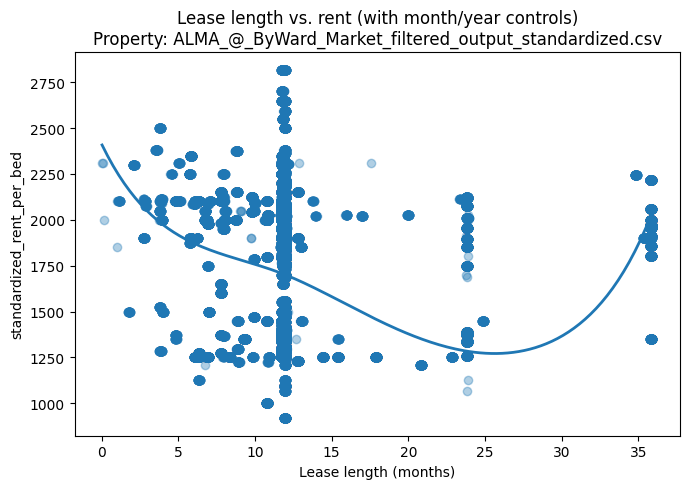

Model summary for ALMA_@_Guelph_filtered_output_standardized.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     7339.
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:29:13   Log-Likelihood:                 24309.
No. Observations:              119534   AIC:                        -4.858e+04
Df Residuals:                  119517   BIC:                        -4.842e+04
Df Model:                          16                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2864780536.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


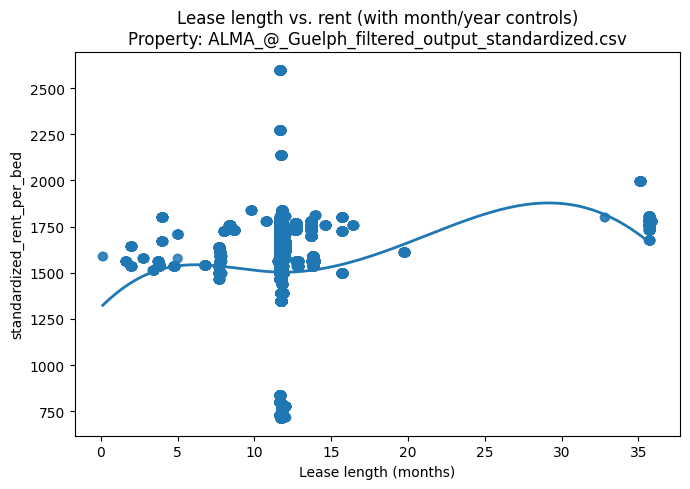

Model summary for ALMA_@_Oshawa_filtered_output_standardized.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     6359.
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:29:15   Log-Likelihood:                 37334.
No. Observations:               70362   AIC:                        -7.463e+04
Df Residuals:                   70342   BIC:                        -7.445e+04
Df Model:                          19                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2864780536.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


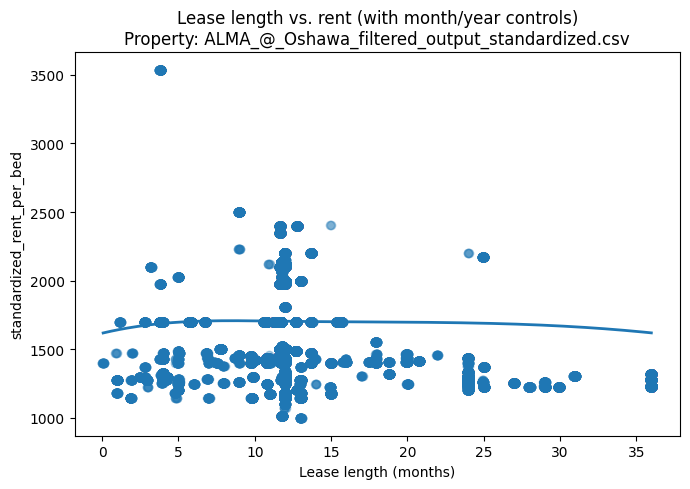

Model summary for ALMA_@_Shaughnessy_Village_filtered_output_standardized.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     1399.
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:29:17   Log-Likelihood:                 13646.
No. Observations:               55680   AIC:                        -2.725e+04
Df Residuals:                   55661   BIC:                        -2.708e+04
Df Model:                          18                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
------------

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2864780536.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


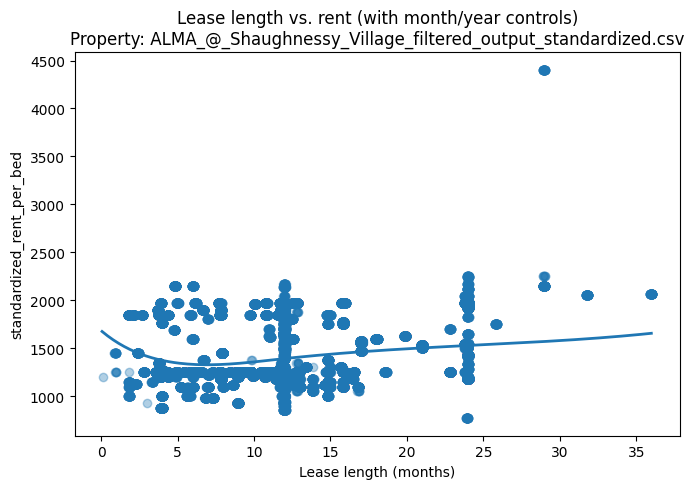

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 17, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2864780536.py:53: Deprecat

Model summary for ALMA_Latin_Quartier_filtered_output_standardized.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                      -0.611
Model:                            OLS   Adj. R-squared:                 -0.617
Method:                 Least Squares   F-statistic:                    0.2315
Date:                Fri, 22 Aug 2025   Prob (F-statistic):              0.630
Time:                        15:29:18   Log-Likelihood:                 256.55
No. Observations:                3683   AIC:                            -481.1
Df Residuals:                    3667   BIC:                            -381.7
Df Model:                          15                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------

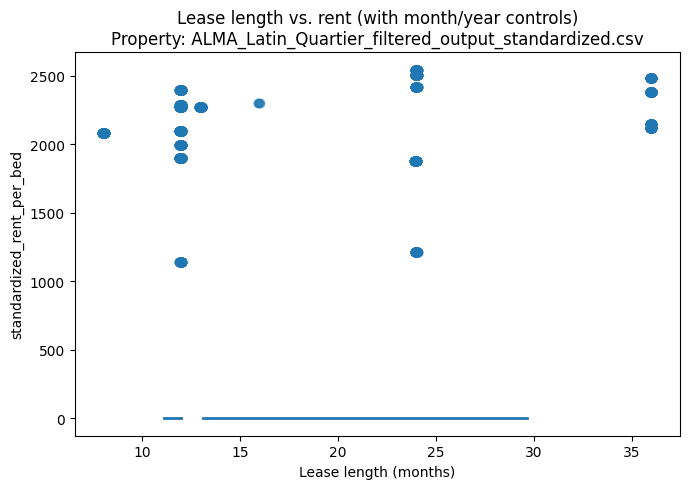

Model summary for ALMA_Sandy_Hill_filtered_output_standardized.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                 5.107e+04
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:29:19   Log-Likelihood:                 14863.
No. Observations:               12593   AIC:                        -2.969e+04
Df Residuals:                   12576   BIC:                        -2.957e+04
Df Model:                          16                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2864780536.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


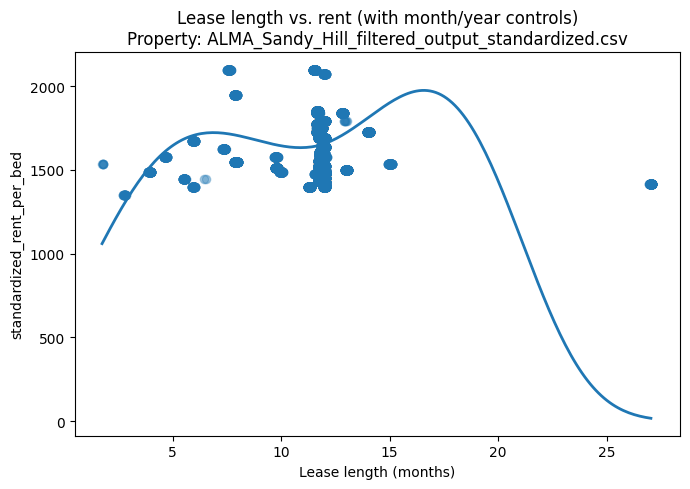

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 19, but rank is 18
  warnings.warn('covariance of constraints does not have full '
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2864780536.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


Model summary for Bridgeport_House_filtered_output_standardized.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                 4.401e+05
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:29:24   Log-Likelihood:                 51384.
No. Observations:              298043   AIC:                        -1.027e+05
Df Residuals:                  298023   BIC:                        -1.025e+05
Df Model:                          19                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------

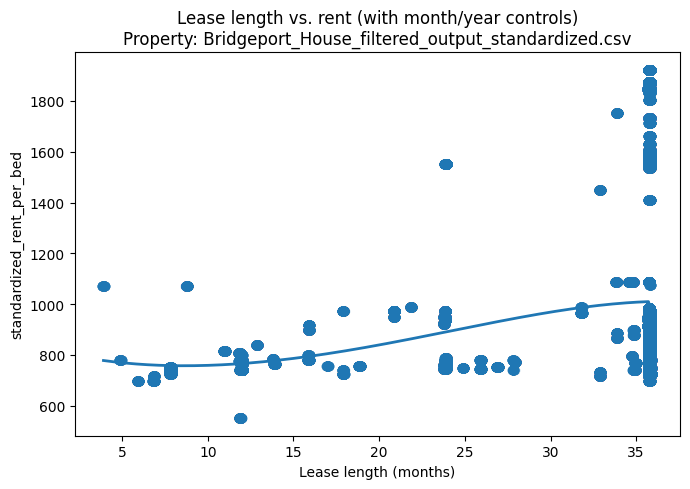

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 14, but rank is 11
  warnings.warn('covariance of constraints does not have full '
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2864780536.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


Model summary for Fergus_House_filtered_output_standardized.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                 2.053e+05
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:29:30   Log-Likelihood:             3.4510e+05
No. Observations:              177537   AIC:                        -6.902e+05
Df Residuals:                  177522   BIC:                        -6.900e+05
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------

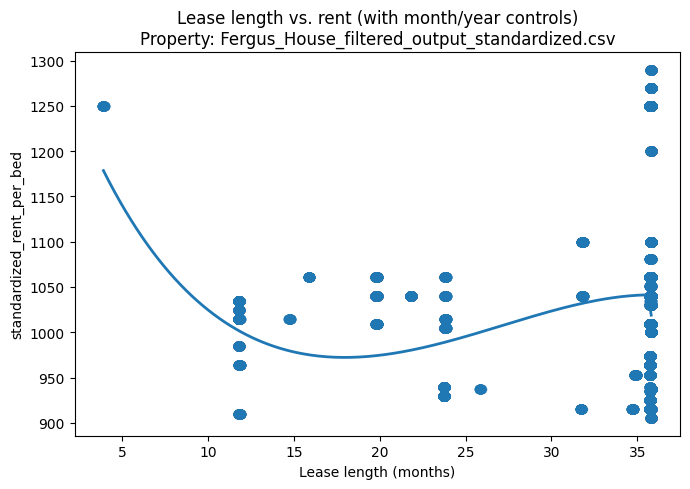

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 10
  warnings.warn('covariance of constraints does not have full '
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2864780536.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


Model summary for Hespeler_House_filtered_output_standardized.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                 1.362e+05
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:29:34   Log-Likelihood:                -3998.8
No. Observations:              164812   AIC:                             8024.
Df Residuals:                  164799   BIC:                             8154.
Df Model:                          12                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------

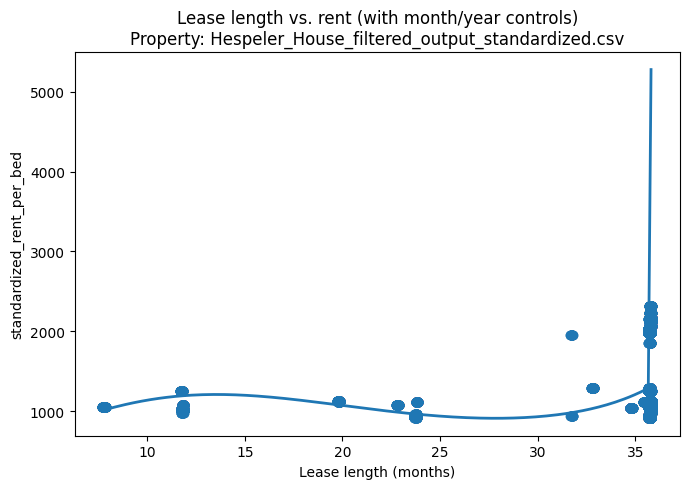

Model summary for King_Street_Towers_filtered_output_standardized.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                 4.249e+05
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:29:43   Log-Likelihood:            -5.9177e+05
No. Observations:              549520   AIC:                         1.184e+06
Df Residuals:                  549502   BIC:                         1.184e+06
Df Model:                          17                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2864780536.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


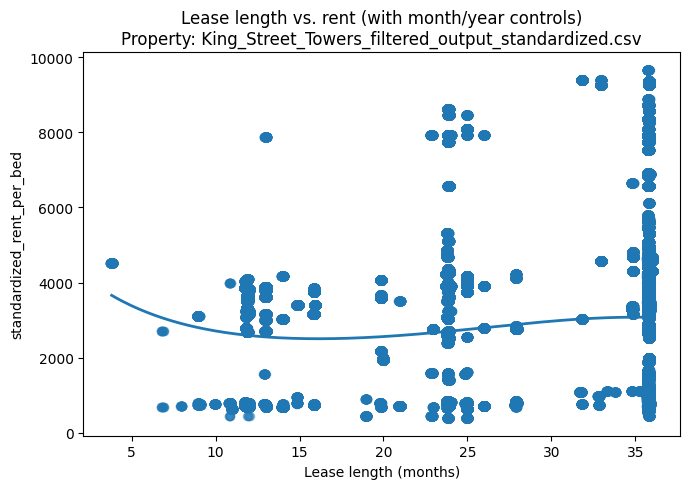

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 19, but rank is 17
  warnings.warn('covariance of constraints does not have full '
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2864780536.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


Model summary for MyRez_on_Lester_filtered_output_standardized.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                 1.577e+05
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:29:48   Log-Likelihood:                 20703.
No. Observations:              262820   AIC:                        -4.137e+04
Df Residuals:                  262800   BIC:                        -4.116e+04
Df Model:                          19                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

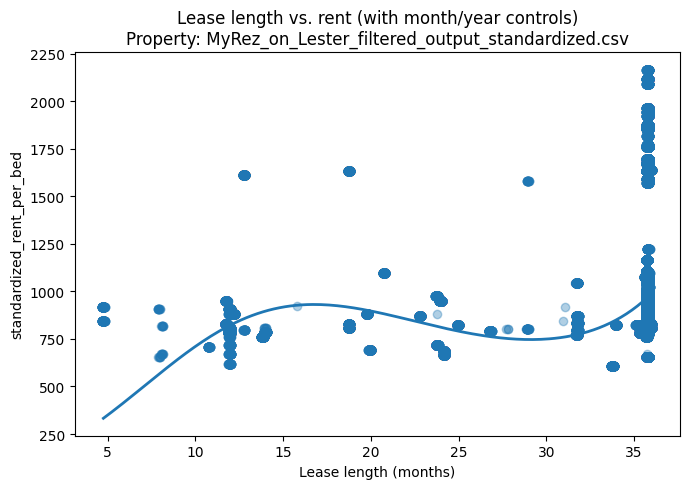

Model summary for Preston_House_filtered_output_standardized.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                 6.483e+04
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:29:52   Log-Likelihood:                 34535.
No. Observations:              188610   AIC:                        -6.904e+04
Df Residuals:                  188594   BIC:                        -6.888e+04
Df Model:                          15                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2864780536.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


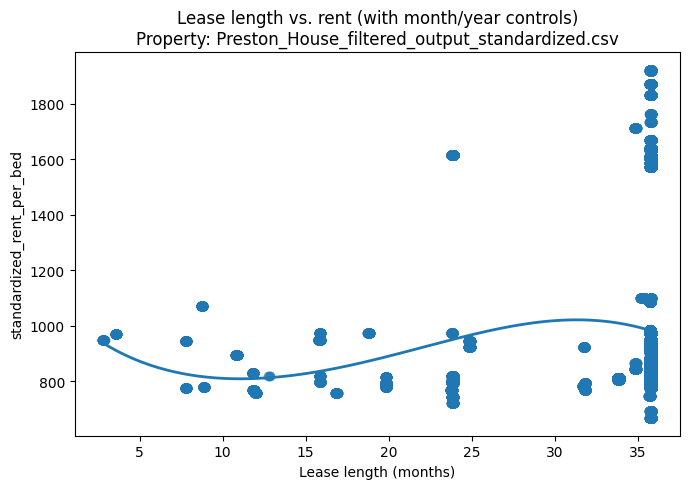

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 13
  warnings.warn('covariance of constraints does not have full '
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2864780536.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


Model summary for See-More_filtered_output_standardized.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                 8.144e+04
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:29:57   Log-Likelihood:            -1.9836e+05
No. Observations:              368286   AIC:                         3.968e+05
Df Residuals:                  368269   BIC:                         3.969e+05
Df Model:                          16                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

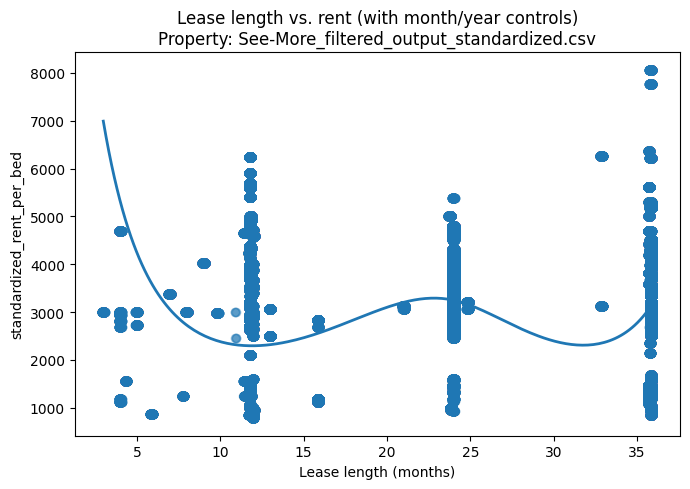

Model summary for The_Arc_filtered_output_standardized.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                 1.442e+04
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:30:02   Log-Likelihood:             1.0815e+05
No. Observations:              305719   AIC:                        -2.163e+05
Df Residuals:                  305699   BIC:                        -2.161e+05
Df Model:                          19                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2864780536.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


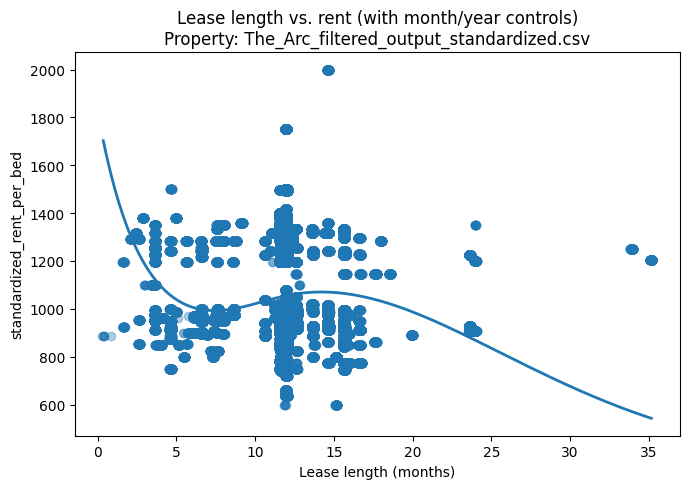

Model summary for The_Quad_at_York_Phase_1_filtered_output_standardized.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     4917.
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:30:10   Log-Likelihood:             2.3144e+05
No. Observations:              514237   AIC:                        -4.629e+05
Df Residuals:                  514218   BIC:                        -4.626e+05
Df Model:                          18                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2864780536.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


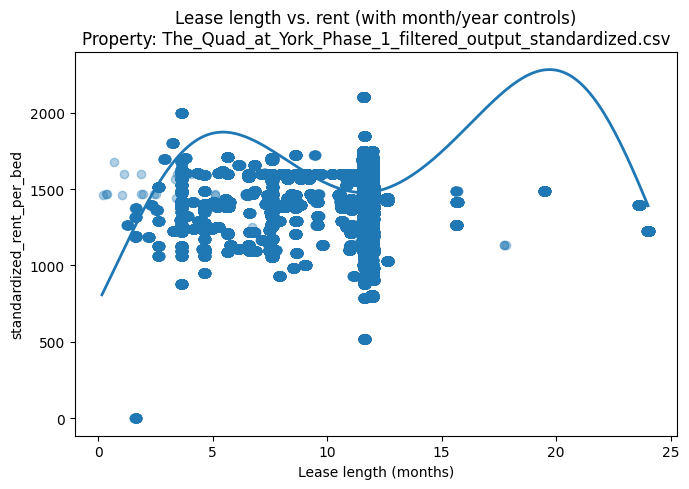

Model summary for The_Quad_at_York_Phase_2_filtered_output_standardized.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     3930.
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:30:27   Log-Likelihood:             3.9694e+05
No. Observations:              449964   AIC:                        -7.938e+05
Df Residuals:                  449945   BIC:                        -7.936e+05
Df Model:                          18                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2864780536.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


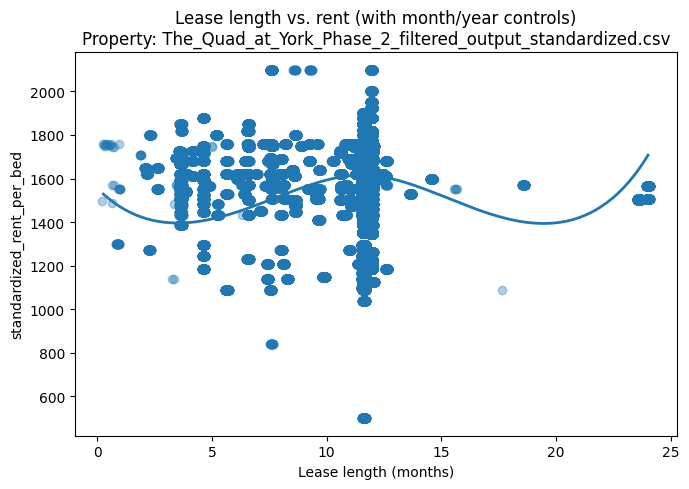

Model summary for West_Village_Suites_filtered_output_standardized.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                 2.109e+05
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:30:34   Log-Likelihood:             1.0165e+05
No. Observations:              238744   AIC:                        -2.033e+05
Df Residuals:                  238725   BIC:                        -2.031e+05
Df Model:                          18                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2864780536.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


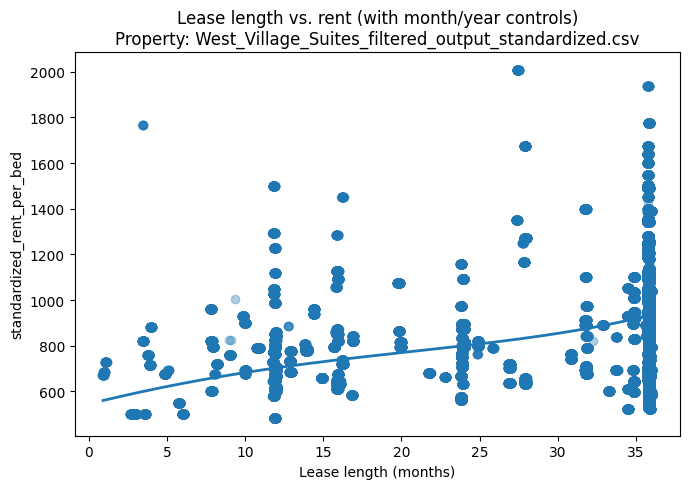

Model summary for Woodroffe_Place_filtered_output_standardized.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     570.4
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:30:37   Log-Likelihood:                 65264.
No. Observations:              110936   AIC:                        -1.305e+05
Df Residuals:                  110917   BIC:                        -1.303e+05
Df Model:                          18                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2864780536.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


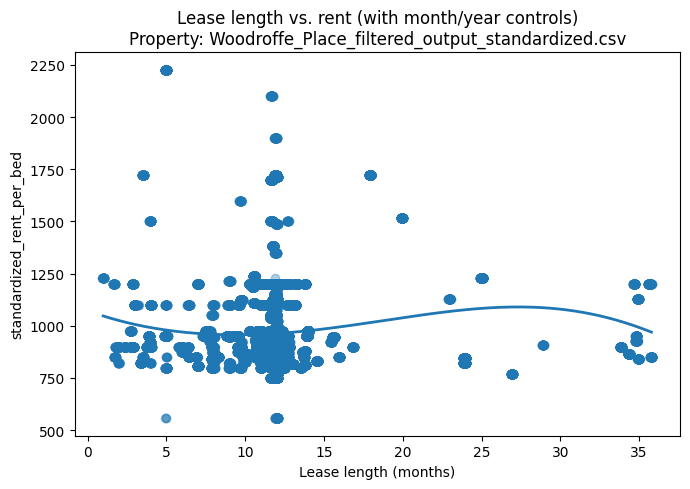

In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
# Read all cleaned files
files = os.listdir("Properties_Cleaned_Rent")
for file in files:
    # Read property
    temp_df = pd.read_csv("Properties_Cleaned_Rent/"+file, low_memory=False)
    temp_df["Lease Start Date"] = pd.to_datetime(temp_df["Lease Start Date"], errors="coerce")
    temp_df["Lease End Date"] = pd.to_datetime(temp_df["Lease End Date"], errors="coerce")

    # Calculate lease length in months (note 365.25/ 12 = 30.4375 days per month)
    temp_df["Lease Length"] = (temp_df["Lease End Date"] - temp_df["Lease Start Date"]).dt.days / 30.4375

    temp_df["Lease Start Year"] = temp_df["Lease Start Date"].dt.year
    temp_df["Lease Start Month"] = temp_df["Lease Start Date"].dt.month

    temp_df["standardized_rent_per_bed"] = pd.to_numeric(temp_df["standardized_rent_per_bed"], errors="coerce")
    
    # Filter out rows with invalid lease lengths or rents
    temp_df = temp_df[(temp_df["Lease Length"].notna()) & (temp_df["standardized_rent_per_bed"] > 0)]
    temp_df = temp_df[(temp_df["Lease Length"] > 0) & (temp_df["Lease Length"] <= 36)]  # reasonable lease lengths (1-36 months)
    temp_df = temp_df[temp_df["Lease Start Month"].notna() & temp_df["Lease Start Year"].notna()]

    # Columns to keep
    cols_keep = ['Unit Space ID', 'Lease Start Date', 'Lease End Date', 'Lease Length', 'Lease Start Year', 'Lease Start Month', 'standardized_rent_per_bed']
    temp_df = temp_df[cols_keep].dropna()
    
    # Log transform and rename columns
    temp_df["Log Scheduled Rent"] = np.log(temp_df["standardized_rent_per_bed"])
    temp_df = temp_df.rename(columns={
        "Log Scheduled Rent": "log_rent",
        "Lease Length": "lease_length",
        "Lease Start Month": "start_month",
        "Lease Start Year": "start_year"
    })

    formula = "log_rent ~ bs(lease_length, df=4, include_intercept=False) + C(start_month) + C(start_year)"
    try:
        model = smf.ols(formula=formula, data=temp_df).fit(cov_type="HC1")
        print(f"Model summary for {file}:\n{model.summary()}\n")

        exog_names = model.model.exog_names
        bs_cols = [i for i, name in enumerate(exog_names) if name.startswith("bs(lease_length")]
        R = np.zeros((len(bs_cols), len(exog_names)))
        for r_i, col_idx in enumerate(bs_cols):
            R[r_i, col_idx] = 1.0
        wald = model.wald_test(R, use_f=True)
        wald_test_results = {
            "F": float(wald.fvalue),
            "df_num": int(wald.df_num),
            "df_denom": int(wald.df_denom),
            "p_value": float(wald.pvalue)
        }

        # Coefficient table
        coef_table = model.summary2().tables[1].reset_index().rename(columns={"index":"term"})
        x_grid = np.linspace(temp_df['lease_length'].min(), temp_df['lease_length'].max(), 200)
        # Build a frame holding typical month/year (use modal month/year)
        modal_month = int(temp_df['start_month'].mode().iloc[0])
        modal_year = int(temp_df['start_year'].mode().iloc[0])
        pred_df = pd.DataFrame({
            "lease_length": x_grid,
            "start_month": modal_month,
        "start_year": modal_year
        })
        pred_log = model.predict(pred_df)
        pred = np.exp(pred_log)

        # Plot
        plt.figure(figsize=(7,5))
        # scatter of observed (jittered)
        jitter = (np.random.rand(len(temp_df)) - 0.5) * 0.15
        plt.scatter(temp_df['lease_length'] + jitter, temp_df['standardized_rent_per_bed'], alpha=0.35)
        plt.plot(x_grid, pred, linewidth=2)
        plt.xlabel("Lease length (months)")
        plt.ylabel("standardized_rent_per_bed")
        plt.title(f"Lease length vs. rent (with month/year controls)\nProperty: {file}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error processing {file}: {e}")


    

In [9]:
GoogleReviewStars = {
    "17Hundred": 3.5,
    "1Eleven": 3.8,
    "1Ten_on_Whyte": 4.2, 
    "308_King": 4.7,
    "417Nelson": 4.9,
    "ALMA_@_ByWard_Market": 4.0,  
    "ALMA_@_Guelph": 4.6,
    "ALMA_@_Oshawa": 3.8,
    "ALMA_@_Shaughnessy_Village": 3.8,
    "ALMA_Latin_Quartier": 5.0,
    "ALMA_Sandy_Hill": 4.2,
    "Bridgeport_House": 3.9,
    "Fergus_House": 4.1,
    "Hespeler_House": 4.0,
    "King_Street_Towers": 3.9,
    "MyRez_on_Lester": 4.1,
    "Preston_House": 4.0,
    "See-More": 4.7,
    "The_Arc": 4.0,
    "The_Quad_at_York_Phase_1": 3.6, 
    "The_Quad_at_York_Phase_2": 3.6,
    "West_Village_Suites": 3.1,
    "Woodroffe_Place": 3.9
}

In [ ]:
files = os.listdir("Properties_Cleaned_Rent")

results = []
for file in files:
    temp_df = pd.read_csv("Properties_Cleaned_Rent/"+file, low_memory=False)
    property_name = file.replace("_filtered_output_standardized", "").split('.')[0]
    avg_revenue_property = temp_df["standardized_rent_per_bed"].mean()
    results.append({
        "PropertyName": property_name,
        "AvgRevenue": avg_revenue_property,
        "GoogleReviewStars": GoogleReviewStars.get(property_name, None)
    })

property_summary = pd.DataFrame(results)
property_summary = property_summary[property_summary["AvgRevenue"].notna()]
property_summary

,PropertyName,AvgRevenue,GoogleReviewStars
0,17Hundred,779.145900,3.5
1,1Eleven,1263.601203,3.8
2,1Ten_on_Whyte,879.374550,4.2
3,308_King,1274.358720,4.7
4,417Nelson,1301.105451,4.9
5,ALMA_@_ByWard_Market,1760.542739,4.0
6,ALMA_@_Guelph,1558.540953,4.6
7,ALMA_@_Oshawa,1508.729685,3.8
8,ALMA_@_Shaughnessy_Village,1408.585573,3.8
9,ALMA_Latin_Quartier,2133.702047,5.0


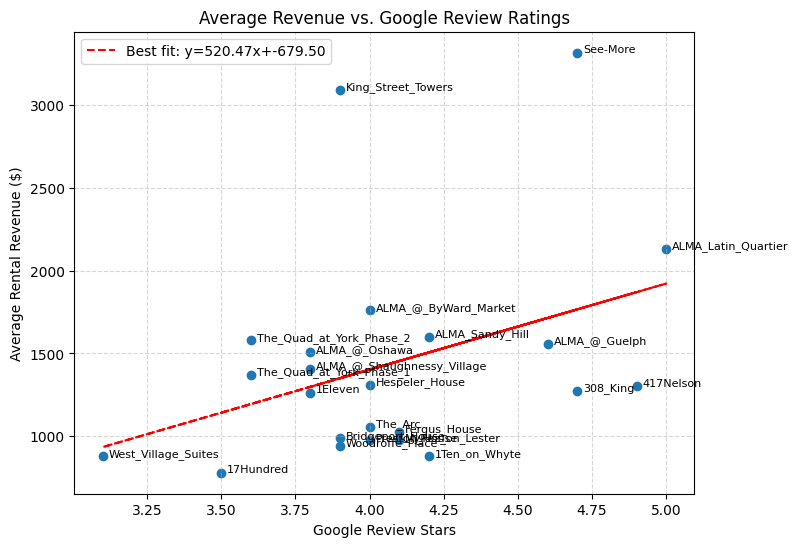

In [11]:

plt.figure(figsize=(8,6))
plt.scatter(property_summary["GoogleReviewStars"], property_summary["AvgRevenue"])

# Labels
for i, row in property_summary.iterrows():
    plt.text(row["GoogleReviewStars"]+0.02, row["AvgRevenue"], row["PropertyName"], fontsize=8)

# Best-fit line
x = property_summary["GoogleReviewStars"]
y = property_summary["AvgRevenue"]

# Fit a straight line (degree=1 polynomial)
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color="red", linestyle="--", label=f"Best fit: y={m:.2f}x+{b:.2f}")

plt.xlabel("Google Review Stars")
plt.ylabel("Average Rental Revenue ($)")
plt.title("Average Revenue vs. Google Review Ratings")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


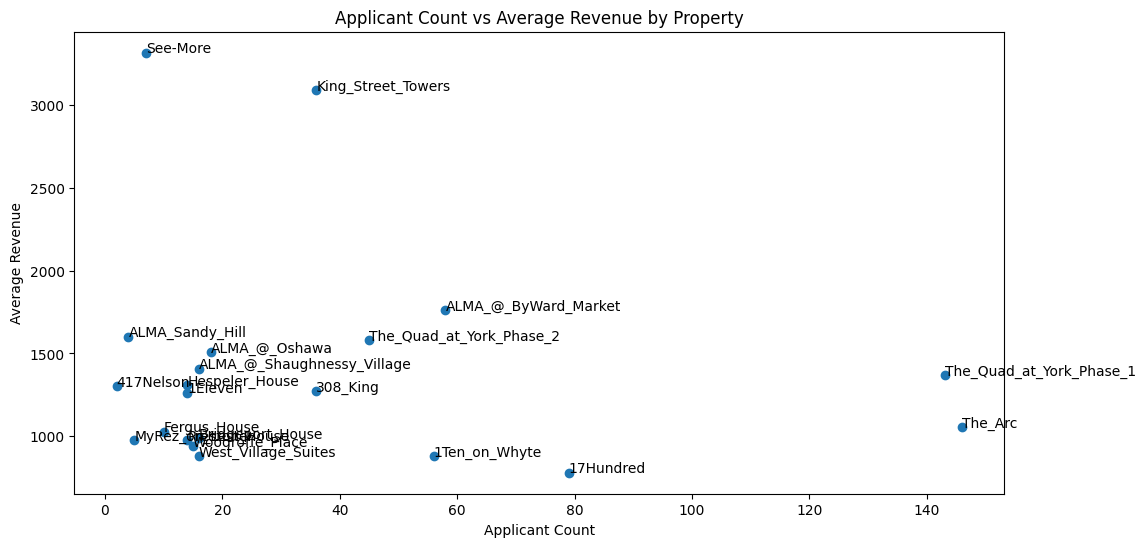

In [14]:
# Replace spaces with underscores in the property column
currentApplicantsdf = pd.read_csv("Current Applicants.csv")
currentApplicantsdf["Property"] = currentApplicantsdf["Property"].str.replace(" ", "_")


# Now count again
property_counts = currentApplicantsdf["Property"].value_counts()


property_counts_df = property_counts.reset_index()
property_counts_df.columns = ["PropertyName", "ApplicantCount"]
property_counts_df["PropertyName"] = property_counts_df["PropertyName"].astype(str)
merged_df = pd.merge(property_counts_df, property_summary, on="PropertyName", how="left")

plt.figure(figsize=(12,6))
plt.scatter(merged_df["ApplicantCount"], merged_df["AvgRevenue"])

for i, txt in enumerate(merged_df["PropertyName"]):
    plt.annotate(txt, (merged_df["ApplicantCount"].iloc[i], merged_df["AvgRevenue"].iloc[i]))

plt.xlabel("Applicant Count")
plt.ylabel("Average Revenue")
plt.title("Applicant Count vs Average Revenue by Property")
plt.show()

In [20]:
floors_per_building = {
    "17Hundred": 6, # divided up into 6 storeys and 4 storeys
    "1Eleven": 16,
    "1Ten_on_Whyte": 4,
    "308_King": 25,
    "417Nelson": 31,
    "ALMA_@_ByWard_Market": 15,
    "ALMA_@_Guelph": 7, # Two 7-storey buildings
    "ALMA_@_Oshawa": 9,
    "ALMA_@_Shaughnessy_Village": 18,
    "ALMA_Latin_Quartier": 3,
    "ALMA_Sandy_Hill": 6,
    "Bridgeport_House": 18,
    "Fergus_House": 21,
    "Hespeler_House": 21,
    "King_Street_Towers": 21, # two towers - one with 17 floors and one with 21 floors
    "MyRez_on_Lester": 18,
    "Preston_House": 17,
    "See-More": 16,
    "The_Arc": 15,
    "The_Quad_at_York_Phase_1": 7,
    "The_Quad_at_York_Phase_2": 6,
    "West_Village_Suites": 9,
    "Woodroffe_Place": 16
}

In [21]:
building_counts = []
files = os.listdir("Properties_Cleaned_Rent")
for file in files:
    df_temp = pd.read_csv("Properties_Cleaned_Rent/"+file)
    df_temp = df_temp[df_temp["standardized_rent_per_bed"] >= 0].dropna(subset=["Unit Space ID"])
    unique_amt = df_temp["Unit Space ID"].nunique()
    avg_rent = df_temp["standardized_rent_per_bed"].mean()
    building_name = os.path.basename(file).replace("_filtered_output_standardized.csv", "")
    floors = floors_per_building[building_name]
    avg_units_per_floor = unique_amt / floors
    building_counts.append({"Building": building_name, "Count": unique_amt, "Floors": floors, "AvgRent": avg_rent, "Average Units Per Floor": avg_units_per_floor})

building_counts_df = pd.DataFrame(building_counts)
building_counts_df

C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\3876940610.py:4: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv("Properties_Cleaned_Rent/"+file)
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\3876940610.py:4: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv("Properties_Cleaned_Rent/"+file)
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\3876940610.py:4: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv("Properties_Cleaned_Rent/"+file)
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\3876940610.py:4: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv("Properties_Cleaned_Rent/"+file)
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\3876940610.py:4: DtypeWarning: Columns

,Building,Count,Floors,AvgRent,Average Units Per Floor
0,17Hundred,588,6,779.145900,98.000000
1,1Eleven,358,16,1263.601203,22.375000
2,1Ten_on_Whyte,60,4,879.374550,15.000000
3,308_King,658,25,1274.358720,26.320000
4,417Nelson,88,31,1301.105451,2.838710
5,ALMA_@_ByWard_Market,565,15,1760.542739,37.666667
6,ALMA_@_Guelph,180,7,1558.540953,25.714286
7,ALMA_@_Oshawa,206,9,1508.729685,22.888889
8,ALMA_@_Shaughnessy_Village,211,18,1408.585573,11.722222
9,ALMA_Latin_Quartier,38,3,2133.702047,12.666667


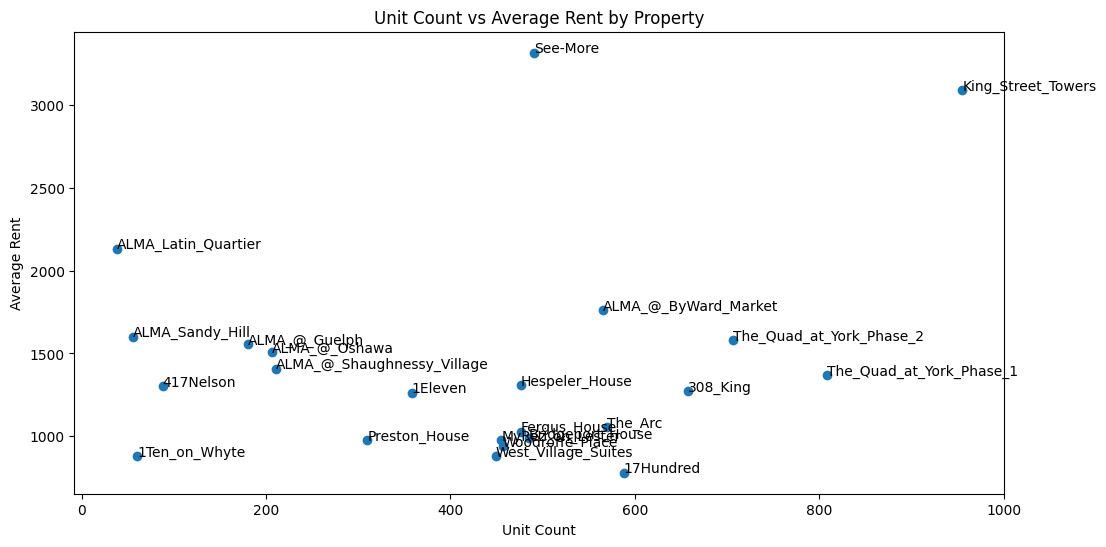

In [22]:
plt.figure(figsize=(12,6))
plt.scatter(building_counts_df["Count"], building_counts_df["AvgRent"])

for i, txt in enumerate(building_counts_df["Building"]):
    plt.annotate(txt, (building_counts_df["Count"].iloc[i], building_counts_df["AvgRent"].iloc[i]))

plt.xlabel("Unit Count")
plt.ylabel("Average Rent")
plt.title("Unit Count vs Average Rent by Property")
plt.show()

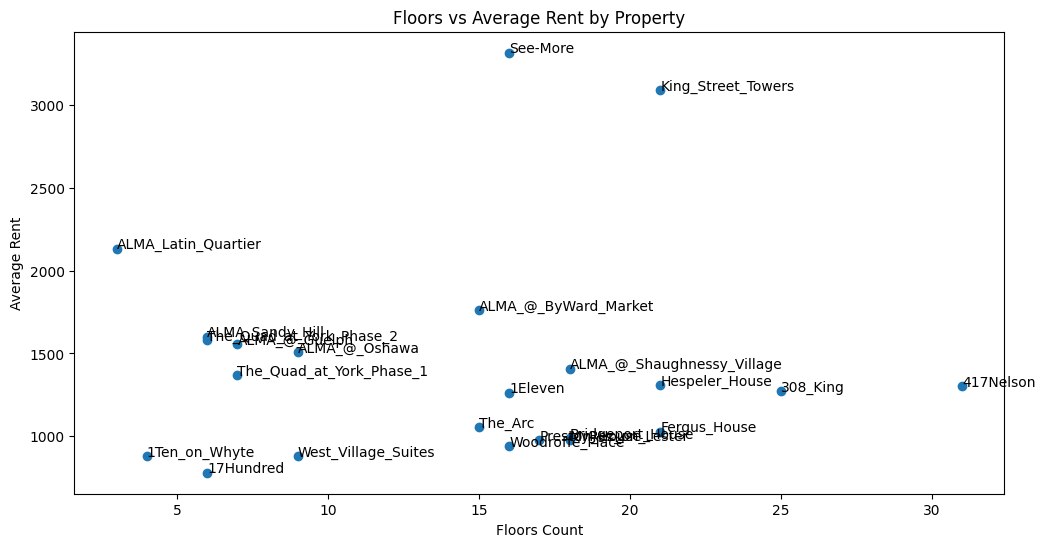

In [23]:
plt.figure(figsize=(12,6))
plt.scatter(building_counts_df["Floors"], building_counts_df["AvgRent"])

for i, txt in enumerate(building_counts_df["Building"]):
    plt.annotate(txt, (building_counts_df["Floors"].iloc[i], building_counts_df["AvgRent"].iloc[i]))

plt.xlabel("Floors Count")
plt.ylabel("Average Rent")
plt.title("Floors vs Average Rent by Property")
plt.show()

C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2320248174.py:13: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv("Properties_Cleaned_Rent/"+file)
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2320248174.py:13: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv("Properties_Cleaned_Rent/"+file)
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2320248174.py:13: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv("Properties_Cleaned_Rent/"+file)
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2320248174.py:13: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv("Properties_Cleaned_Rent/"+file)
C:\Users\JackE\AppData\Local\Temp\ipykernel_19996\2320248174.py:13: DtypeWarning: Co

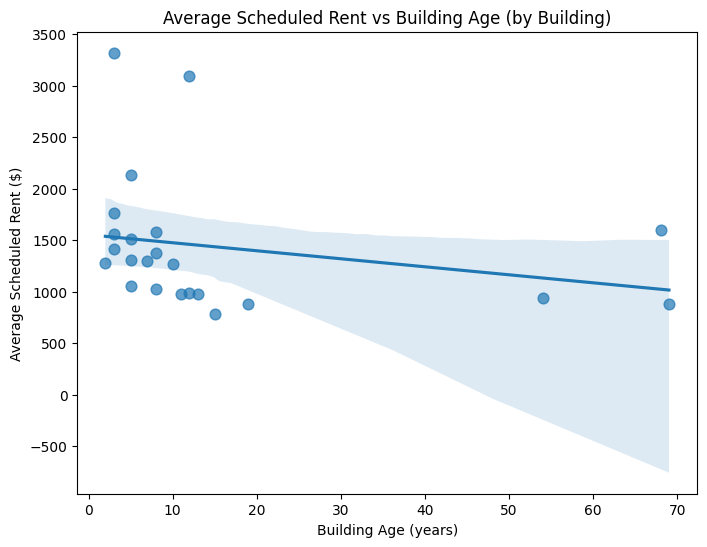

(                      Building  Age      AvgRent
 0                    17Hundred   15   779.145900
 1                      1Eleven   10  1263.601203
 2                1Ten_on_Whyte   69   879.374550
 3                     308_King    2  1274.358720
 4                    417Nelson    7  1301.105451
 5         ALMA_@_ByWard_Market    3  1760.542739
 6                ALMA_@_Guelph    3  1558.540953
 7                ALMA_@_Oshawa    5  1508.729685
 8   ALMA_@_Shaughnessy_Village    3  1408.585573
 9          ALMA_Latin_Quartier    5  2133.702047
 10             ALMA_Sandy_Hill   68  1601.865562
 11            Bridgeport_House   12   986.564814
 12                Fergus_House    8  1027.493853
 13              Hespeler_House    5  1309.880469
 14          King_Street_Towers   12  3094.005325
 15             MyRez_on_Lester   11   975.629066
 16               Preston_House   13   974.944881
 17                    See-More    3  3318.191607
 18                     The_Arc    5  1055.894513


In [26]:
import os
from glob import glob
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

directory = os.getcwd()
files = os.listdir("Properties_Cleaned_Rent")
building_stats = []
for file in files:
    df_temp = pd.read_csv("Properties_Cleaned_Rent/"+file)
    df_temp = df_temp.dropna(subset=["standardized_rent_per_bed", "Property Year Built"])
    df_temp = df_temp[df_temp["standardized_rent_per_bed"] > 0]
    age = 2025 - df_temp["Property Year Built"].iloc[0]
    avg_rent = df_temp["standardized_rent_per_bed"].mean()
    building_name = os.path.basename(file).replace("_filtered_output_standardized.csv", "")
    building_stats.append({"Building": building_name, "Age": age, "AvgRent": avg_rent})

building_stats_df = pd.DataFrame(building_stats)

slope, intercept, r_value, p_value, std_err = stats.linregress(
    building_stats_df["Age"], building_stats_df["AvgRent"]
)

regression_results = {
    "Line": f"Rent = {slope:.2f} * Age + {intercept:.2f}",
    "R²": r_value**2,
    "p-value": p_value
}

plt.figure(figsize=(8,6))
sns.regplot(data=building_stats_df, x="Age", y="AvgRent", scatter_kws={'s':60, 'alpha':0.7})
plt.title("Average Scheduled Rent vs Building Age (by Building)")
plt.xlabel("Building Age (years)")
plt.ylabel("Average Scheduled Rent ($)")
plt.show()

building_stats_df, regression_results